# Knowledge Distillation: Generating Training Data from a Teacher Model

This notebook demonstrates the first step in knowledge distillation: generating high-quality training data from a large "teacher" model. Knowledge distillation is a technique where a smaller, more efficient model learns from a larger, more powerful model rather than directly from raw data.

![](../../lab_manual/images/step-1.png)

## What You'll Learn
- How to load and format multiple-choice questions
- How to send these questions to a large language model (DeepSeek-V3)
- How to collect and save the teacher model's responses
- How to analyze the quality of generated training data

## Prerequisites
- Access to an Azure AI model endpoint (DeepSeek-V3)
- Azure credentials set up in a local.env file
- Python environment with necessary libraries

## Setup Instructions
1. **Azure Authentication**: Ensure you're logged in to Azure using `az login --use-device-code` in a terminal
2. **Kernel Selection**: Change the Jupyter kernel to **"Python 3.10 AzureML"** using the selector in the top right
3. **Environment File**: Ensure your `local.env` file exists with proper credentials


## 1. Install Required Packages

First, we'll install the packages needed for this notebook. The `dotenv-azd` package allows us to securely load environment variables from Azure Developer CLI (AZD) environments and/or local .env files. This is how we'll access our Azure credentials without hardcoding sensitive information.

In [2]:
pip install dotenv-azd

Note: you may need to restart the kernel to use updated packages.


## 2. Install Data Handling Libraries

Next, we install two important packages:

- `datasets`: Hugging Face's library that provides easy access to thousands of publicly available datasets
- `tqdm`: A progress bar library that helps visualize long-running operations

The `-U` flag ensures we get the latest versions of these packages.

In [3]:
pip install datasets tqdm -U

Note: you may need to restart the kernel to use updated packages.


## 3. Import Dataset Libraries

Now we import the libraries needed to work with our datasets:

- `load_dataset`: A function from Hugging Face that lets us download and use public datasets
- `ABC` (Abstract Base Class): A Python feature that helps us create a framework for our dataset handling

In [4]:
from datasets import load_dataset
from abc import ABC

## 4. Create Base Dataset Class

Here we define our base class for handling datasets. This creates a common structure that all our dataset handlers will follow:

1. We're using Python's Abstract Base Class (`ABC`) as a foundation
2. The class initializes three important attributes that will track our data files:
   - `train_data_file_name`: For our training data
   - `test_data_file_name`: For our test data
   - `eval_data_file_name`: For our evaluation/validation data

These file names are initially set to `None` and will be filled in later when we create our datasets.

In [5]:
class InputDataset(ABC):
    def __init__(self):
        super().__init__()
        (
            self.train_data_file_name,
            self.test_data_file_name,
            self.eval_data_file_name,
        ) = (None, None, None)

## 5. Create Specialized Dataset Handler

This class extends our base `InputDataset` to handle loading data specifically from Hugging Face. The `load_hf_dataset` method does the following:

1. Loads a dataset from Hugging Face by name (e.g., "tau/commonsense_qa")
2. Creates three different data splits:
   - Training data: Used to generate examples for our model
   - Validation data: Used to evaluate during training
   - Test data: Used for final evaluation

3. Controls how many examples we take from each split using the sample size parameters

The code handles two scenarios:
- Datasets that already have validation splits
- Datasets that only have train/test splits (in which case it creates a validation set from the training data)

In [6]:
class CQnAHuggingFaceInputDataset(InputDataset):
    """
    Loads the HuggingFace dataset
    """

    def __init__(self):
        super().__init__()

    def load_hf_dataset(
        self,
        dataset_name,
        train_sample_size=10,
        val_sample_size=10,
        test_sample_size=10,
        train_split_name="train",
        val_split_name="validation",
        test_split_name="test",
    ):
        full_dataset = load_dataset(dataset_name)

        if val_split_name is not None:
            train_data = full_dataset[train_split_name].select(range(train_sample_size))
            val_data = full_dataset[val_split_name].select(range(val_sample_size))
            test_data = full_dataset[test_split_name].select(range(test_sample_size))
        else:
            train_val_data = full_dataset[train_split_name].select(
                range(train_sample_size + val_sample_size)
            )
            train_data = train_val_data.select(range(train_sample_size))
            val_data = train_val_data.select(
                range(train_sample_size, train_sample_size + val_sample_size)
            )
            test_data = full_dataset[test_split_name].select(range(test_sample_size))

        return train_data, val_data, test_data

## 6. Load the CommonsenseQA Dataset

Now we'll actually load our dataset using the classes we defined. Here's what this cell does:

1. **Define sample sizes**: We're using 100 examples each for training and validation to keep this notebook running quickly

2. **Choose a dataset**: We're using "tau/commonsense_qa", which contains multiple-choice questions that test common sense reasoning

3. **Create an instance of our dataset handler** and use it to load the data

4. **Print the dataset sizes** to confirm everything loaded correctly

The CommonsenseQA dataset is perfect for knowledge distillation because it contains challenging questions with five possible answers (labeled A through E). This will test how well our model has learned to reason like the teacher model.

In [7]:
# We can define train and test sample sizes here. Validation size is kept same as test sample size
train_sample_size = 100
val_sample_size = 100

# Sample notebook using the dataset: https://huggingface.co/datasets/tau/commonsense_qa
dataset_name = "tau/commonsense_qa"
input_dataset = CQnAHuggingFaceInputDataset()

# Note: train_split_name and test_split_name can vary by dataset. They are passed as arguments in load_hf_dataset.
# If validation_split_name is None, the below function will split the train set to create the specified sized validation set.
train, val, _ = input_dataset.load_hf_dataset(
    dataset_name=dataset_name,
    train_sample_size=train_sample_size,
    val_sample_size=val_sample_size,
    train_split_name="train",
    val_split_name="validation",
)

print("Len of train data sample is " + str(len(train)))
print("Len of validation data sample is " + str(len(val)))

Len of train data sample is 100
Len of validation data sample is 100


## 7. Create Data Directory

This simple command creates a directory called `data` where we'll store our processed files. The `-p` flag ensures that:

1. If the directory already exists, no error will occur
2. If parent directories don't exist, they will be created automatically

This is where we'll store our questions and the teacher model's answers.

In [8]:
! mkdir -p data

## 8. Set Output File Path

Here we define the path where we'll save our processed training data. The file will be called `train_original_data.jsonl` in the data directory we just created.

The `.jsonl` extension indicates this is a JSON Lines file format - a convenient format for large datasets where each line is a valid JSON object. This format is useful because:

- It allows processing one example at a time (streaming)
- Each example is self-contained on its own line
- It's human-readable and easily parsed by most programming languages

In [9]:
train_data_path = "./data/train_original_data.jsonl"

## 9. Import JSON Library

Here we import the `json` module, which is part of Python's standard library. This module provides functions to:

- Convert Python objects to JSON strings (`json.dumps()`)
- Parse JSON strings into Python objects (`json.loads()`)
- Write JSON data to files (`json.dump()`)
- Read JSON data from files (`json.load()`)

We'll use these functions to format and save our questions and answers in a structured way.

In [10]:
import json

## 10. Format Questions for the Teacher Model

This cell prepares our questions in the format required by the teacher model. Here's what happens step-by-step:

1. **Define prompts**:
   - A system prompt that tells the model to answer with only one letter (A, B, C, D, or E)
   - A template for user messages that formats each question and its answer choices

2. **Create/clear the output file** to ensure we start with a clean file

3. **Process each example** in our training dataset:
   - Extract the question and its multiple-choice options
   - Format the answer choices with their labels (A, B, C, D, E)
   - Create a message structure with system and user prompts
   - Save each formatted example to our JSONL file

4. **Add error handling** and progress tracking

5. **Validate the file creation** by checking the first line

The resulting file will contain all our questions formatted in a way that's ready to be sent to the teacher model.

In [11]:
system_prompt = "You are a helpful assistant. Your output should only be one of the five choices: 'A', 'B', 'C', 'D', or 'E'."
user_prompt_template = "Answer the following multiple-choice question by selecting the correct option.\n\nQuestion: {question}\nAnswer Choices:\n{answer_choices}"

# First, create/truncate the file to ensure it's empty and exists
with open(train_data_path, "w", encoding='utf-8') as f:
    pass  # Just create the file, we'll append to it later

print(f"Generating training data and writing to {train_data_path}")

# Check if train data has expected structure
if len(train) == 0:
    print("Error: Train dataset is empty!")
else:
    print(f"Sample train data keys: {list(train[0].keys())}")
    
    # Verify train data has the expected fields before processing
    sample = train[0]
    if 'question' in sample and 'choices' in sample:
        for i, row in enumerate(train):
            try:
                data = {"messages": []}
                data["messages"].append(
                    {
                        "role": "system",
                        "content": system_prompt,
                    }
                )
                question, choices = row["question"], row["choices"]
                labels, choice_list = choices["label"], choices["text"]
                answer_choices = [
                    "({}) {}".format(labels[i], choice_list[i]) for i in range(len(labels))
                ]
                answer_choices = "\n".join(answer_choices)
                data["messages"].append(
                    {
                        "role": "user",
                        "content": user_prompt_template.format(
                            question=question, answer_choices=answer_choices
                        ),
                    }
                )
                
                # Write data as valid JSON line
                with open(train_data_path, "a", encoding='utf-8') as f:
                    f.write(json.dumps(data, ensure_ascii=False) + "\n")
                
                if i % 10 == 0:  # Show progress every 10 items
                    print(f"Processed {i+1}/{len(train)} questions", end="\r")
                    
            except Exception as e:
                print(f"\nError processing row {i}: {str(e)}")
                print(f"Row data: {row}")
        
        print(f"\nSuccessfully wrote {len(train)} questions to {train_data_path}")
        
        # Validate the file has content
        with open(train_data_path, "r", encoding='utf-8') as f:
            first_line = f.readline().strip()
            print(f"File validation: {'SUCCESS' if first_line else 'FAILED - Empty file'}")
            if first_line:
                # Try parsing the first line to validate JSON
                try:
                    json_data = json.loads(first_line)
                    print(f"JSON validation: SUCCESS")
                except json.JSONDecodeError as e:
                    print(f"JSON validation: FAILED - {str(e)}")
    else:
        print(f"Error: Train data doesn't have the expected structure. Found keys: {list(sample.keys())}")
        print("Expected 'question' and 'choices' keys in each sample.")

Generating training data and writing to ./data/train_original_data.jsonl
Sample train data keys: ['id', 'question', 'question_concept', 'choices', 'answerKey']
Processed 91/100 questions
Successfully wrote 100 questions to ./data/train_original_data.jsonl
File validation: SUCCESS
JSON validation: SUCCESS


## 11. Load Environment Variables

This cell loads the configuration and credentials needed to connect to our teacher model. Instead of hardcoding sensitive information like API keys, we use environment variables for better security:

1. `load_azd_env()`: Tries to load variables from an Azure Developer CLI (AZD) environment if available
2. `load_dotenv()`: Falls back to loading from a local `.env` file

This approach ensures our credentials remain secure and can be easily changed without modifying the code. The environment variables should include details for connecting to the Azure AI services where our teacher model is hosted.

In [12]:
import os
from dotenv_azd import load_azd_env
from dotenv import load_dotenv

# Load environment variables from current AZD environment if available
load_azd_env(quiet=True)

# Load environment variables from local.env file if it exists
load_dotenv(dotenv_path="local.env")

True

## 12. Access Teacher Model Credentials

Now we retrieve the specific credentials needed to access our teacher model from the environment variables. We need three key pieces of information:

1. `teacher_model_name`: The name of the model we'll be using (e.g., "DeepSeek-V3")
2. `teacher_model_endpoint_url`: The URL where the model API is hosted
3. `teacher_model_api_key`: The authentication key to access the service

We print confirmation that these values were loaded (without revealing the actual API key for security reasons). This helps verify our setup is correct before proceeding.

Make sure these environment variables are set in your `local.env` file or AZD environment before running this notebook.

In [13]:
# Get Azure AI Foundry credentials from environment variables
teacher_model_name = os.getenv('TEACHER_MODEL_NAME')
teacher_model_endpoint_url = os.getenv('TEACHER_MODEL_ENDPOINT')
teacher_model_api_key = os.getenv('TEACHER_MODEL_KEY')

# Print values for debugging (remove in production)
print(f"Teacher Model Name: {teacher_model_name}")
print(f"Teacher Model Endpoint: {teacher_model_endpoint_url}")
# Don't print the API key for security reasons
print(f"Teacher Model API Key loaded: {'Yes' if teacher_model_api_key else 'No'}")

Teacher Model Name: DeepSeek-V3
Teacher Model Endpoint: https://southcentralus.api.cognitive.microsoft.com/models
Teacher Model API Key loaded: Yes


## 13. Install Azure AI Inference SDK

Here we install the `azure-ai-inference` package, which is Microsoft's official SDK for interacting with Azure AI services. This library provides:

1. Client classes to connect to Azure AI models
2. Methods to send prompts and receive responses
3. Classes to structure messages in the expected chat format
4. Functionality to set parameters like temperature and token limits

This modern API makes it easy to communicate with large language models hosted on Azure AI services.

In [14]:
pip install azure-ai-inference

Note: you may need to restart the kernel to use updated packages.


## 14. Import Azure AI and Utility Libraries

Now we import the libraries we'll need to communicate with the teacher model:

1. **Azure AI Inference Classes**:
   - `ChatCompletionsClient`: The main client for sending requests to the model
   - `SystemMessage` and `UserMessage`: Classes to format our prompts correctly
   - `AzureKeyCredential`: For authentication with our API key

2. **Utility Libraries**:
   - `json`: For working with JSON data (imported earlier)
   - `os`: For accessing environment variables
   - `tqdm`: For showing progress bars during processing

These libraries give us everything we need to send our questions to the teacher model and process its responses.

In [15]:
import os
import json
from azure.ai.inference import ChatCompletionsClient
from azure.ai.inference.models import SystemMessage, UserMessage
from azure.core.credentials import AzureKeyCredential
from tqdm import tqdm

## 15. Define Question Processing Function

This function handles sending a single question to the teacher model and processing its response. Here's how it works:

1. **Create message objects** from our JSON data:
   - Converts system prompts to `SystemMessage` objects
   - Converts user prompts to `UserMessage` objects

2. **Sends the messages** to the teacher model through the Azure AI client

3. **Processes the response** and formats it for our training data

4. **Handles errors** gracefully by returning an error message if something goes wrong

The function returns a dictionary containing:
- The original question
- The model's response (answer)
- The full response object (for debugging)

In [16]:
def process_question(question_data):
    try:
        messages = []
        for msg in question_data["messages"]:
            if msg["role"] == "system":
                messages.append(SystemMessage(content=msg["content"]))
            elif msg["role"] == "user":
                messages.append(UserMessage(content=msg["content"]))

        response = client.complete(
            messages=messages,
            model=model_name,
            max_tokens=10000  # Reduced since we just need short answers like A, B, C, D, or E
        )

        return {
            "question": question_data["messages"][1]["content"],
            "response": response.choices[0].message.content,
            "full_response": response
        }
    except Exception as e:
        return {
            "question": question_data["messages"][1]["content"] if len(question_data["messages"]) > 1 else "Error",
            "response": f"Error: {str(e)}",
            "full_response": None
        }

## 16. Initialize Azure AI Client

Now we create the Azure AI client that will connect to our teacher model. This client handles all communication with the Azure AI service:

1. **Set up the endpoint URL** using our environment variable
2. **Set the model name** to specify which model to use
3. **Create the client** with our endpoint and authentication credentials

This client will be used by our `process_question` function to send questions to the teacher model.

In [17]:
endpoint = f"{teacher_model_endpoint_url}"
model_name = teacher_model_name
key = teacher_model_api_key
client = ChatCompletionsClient(endpoint=endpoint, credential=AzureKeyCredential(key))

## 17. Process Questions with the Teacher Model

This section contains the main processing loop that sends our formatted questions to the teacher model. Here's what this code does:

1. **Validates the input file** to ensure it exists and has valid JSON content

2. **Sets up a progress bar** to track processing in real-time

3. **Processes each question** by:
   - Reading the question data from the file
   - Sending it to our `process_question` function
   - Adding the result to our results list
   - Updating the progress bar

4. **Handles errors** that might occur during processing

5. **Reports overall statistics** at the end

This is the core of our knowledge distillation process - we're collecting expert knowledge from the teacher model that will be used to train our smaller student model.

In [18]:
# Read the JSONL file and process each question
import os
results = []

# Ensure we're using the correct file path
train_data_path = "./data/train_original_data.jsonl"

# Check if the file exists and has content before proceeding
if not os.path.exists(train_data_path):
    print(f"Error: File {train_data_path} does not exist! Please run the previous cells to create it.")
else:
    file_size = os.path.getsize(train_data_path)
    if file_size == 0:
        print(f"Warning: File {train_data_path} exists but is empty (0 bytes)! Please run the data generation cells first.")
    else:
        print(f"File {train_data_path} exists and has {file_size} bytes.")
        
        # Validate first line to ensure it's valid JSON
        with open(train_data_path, 'r', encoding='utf-8') as file:
            first_line = file.readline().strip()
            if not first_line:
                print("Error: File exists but first line is empty!")
            else:
                try:
                    # Try parsing the first JSON line
                    test_json = json.loads(first_line)
                    print("JSON validation: First line is valid JSON")
                    
                    # Continue with processing all lines
                    file.seek(0)  # Go back to start of file
                    total_lines = sum(1 for _ in file if _.strip())
                    
                    print(f"Processing {total_lines} questions from {train_data_path}")
                    file.seek(0)  # Go back to start of file again
                    
                    # Initialize tqdm progress bar
                    progress_bar = tqdm(total=total_lines, desc="Processing questions", unit="question")
                    
                    processed_count = 0
                    error_count = 0
                    
                    for i, line in enumerate(file):
                        if line.strip():  # Skip empty lines
                            try:
                                question_data = json.loads(line)
                                result = process_question(question_data)
                                results.append(result)
                                processed_count += 1
                                
                                # Update progress bar description with latest result
                                progress_bar.set_description(f"Latest answer: {result['response'][:20]}...")
                                progress_bar.update(1)
                                
                            except json.JSONDecodeError as e:
                                error_count += 1
                                print(f"\nError parsing line {i+1}: {str(e)}")
                                print(f"Problematic line content: '{line[:100]}...'")
                                progress_bar.update(1)
                            except Exception as e:
                                error_count += 1
                                print(f"\nError processing line {i+1}: {str(e)}")
                                progress_bar.update(1)
                    
                    progress_bar.close()
                    
                    print(f"\nProcessing complete: {processed_count} successful, {error_count} errors")
                    
                except json.JSONDecodeError as e:
                    print(f"Error: Invalid JSON in file. First line error: {str(e)}")
                    print(f"First line content: '{first_line[:100]}...'")
                    
                except Exception as e:
                    print(f"Error during file processing: {str(e)}")

Latest answer: (B) finger...:  99%|█████████▉| 99/100 [01:41<00:00,  2.42question/s]          


## 18. Save the Teacher Model Responses

Now that we've collected answers from our teacher model, we'll save them to a new file for training our student model. This cell:

1. **Defines the output file path** for our processed training data

2. **Creates a progress bar** to track the saving process

3. **Formats each result** into a simpler structure with just the question and answer

4. **Writes each example** as a line in our output JSON Lines file

The resulting `train_data.jsonl` file will be the training data for our student model in the next notebook. This is the key output from our knowledge distillation process.

In [19]:
output_file_path = "./data/train_data.jsonl"

# Initialize tqdm progress bar for writing results
print(f"Writing {len(results)} processed questions to {output_file_path}")
with open(output_file_path, 'w', encoding='utf-8') as f:
    for result in tqdm(results, desc="Writing results", unit="record"):
        # Extract just the question content (removing the instruction part)
        question_text = result["question"]
        # if "Question: " in question_text:
        #     question_text = question_text.split("Question: ")[1].split("\nAnswer Choices:")[0]

        # Create the simplified output format
        output_line = {
            "Question": question_text,
            "Answer": result["response"]
        }

        # Write as JSONL (one JSON object per line)
        f.write(json.dumps(output_line, ensure_ascii=False) + '\n')

Writing results: 100%|██████████| 100/100 [00:00<00:00, 188508.04record/s]


## 19. Install Visualization Libraries

Before we can analyze our results visually, we need to install the `matplotlib` library. This popular Python library will allow us to create charts and graphs to better understand the data we've collected from the teacher model.

In [20]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


## 20. Analyze Answer Distribution

Now we'll analyze how the teacher model responded to our questions. This helps us understand the quality of our training data and identify any potential issues. This cell:

1. **Counts the frequency** of each answer choice (A, B, C, D, E)

2. **Identifies non-standard responses** (anything other than a single letter)

3. **Creates a bar chart** showing the distribution of answers

4. **Calculates the success rate** - what percentage of responses were valid letter choices

5. **Analyzes problematic responses** if any were found

This analysis helps us ensure that our teacher model is providing high-quality, consistent responses that will be good training examples for our student model.

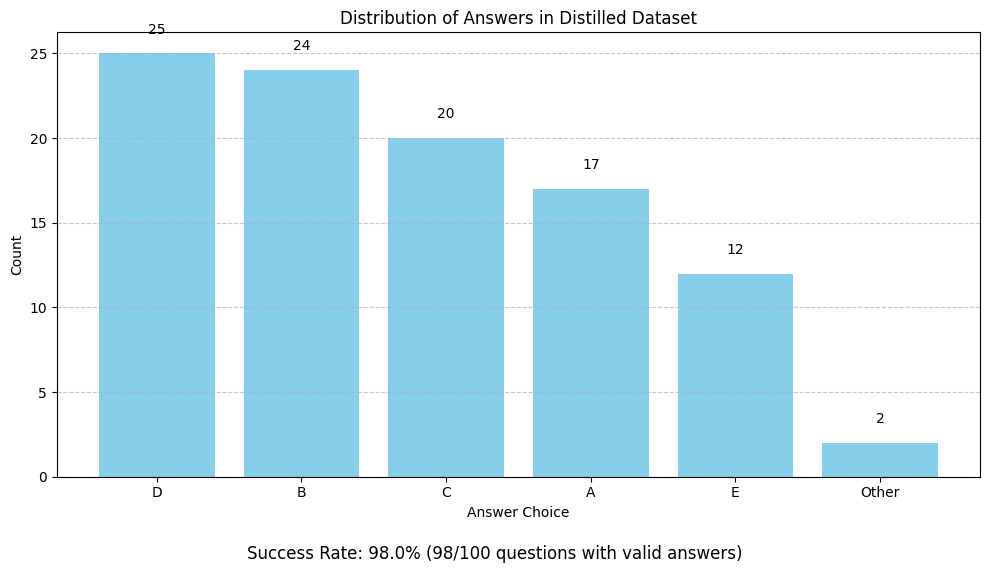


Samples of 'Other' responses (showing up to 10):
  1. 'Error: (content_filter) The response was filtered due to the prompt triggering Microsoft's content management policy. Please modify your prompt and retry.
Code: content_filter
Message: The response was filtered due to the prompt triggering Microsoft's content management policy. Please modify your prompt and retry.
Inner error: {
    "code": "ResponsibleAIPolicyViolation",
    "content_filter_result": {
        "hate": {
            "filtered": false,
            "severity": "safe"
        },
        "self_harm": {
            "filtered": false,
            "severity": "safe"
        },
        "sexual": {
            "filtered": true,
            "severity": "medium"
        },
        "violence": {
            "filtered": false,
            "severity": "safe"
        }
    }
}'
  2. 'Error: (content_filter) The response was filtered due to the prompt triggering Microsoft's content management policy. Please modify your prompt and 

In [21]:
# Visualize the distillation results
import matplotlib.pyplot as plt
import pandas as pd
import re

# Count occurrences of each answer
answer_counts = {}
other_responses = []

for result in results:
    answer = result['response'].strip()
    
    # Try to extract just the letter if there's additional text
    # This regex matches: A, A., A), (A), (A) text
    match = re.search(r'(?:^|\(|\s)([A-E])(?:\)|\.|\s|$)', answer, re.IGNORECASE)
    if match:
        answer = match.group(1).upper()  # Extract just the letter and convert to uppercase
        answer_counts[answer] = answer_counts.get(answer, 0) + 1
    else:
        # For non-standard answers
        answer_counts['Other'] = answer_counts.get('Other', 0) + 1
        # Store problematic responses for analysis
        other_responses.append(answer)

# Create a DataFrame for visualization
df = pd.DataFrame(list(answer_counts.items()), columns=['Answer', 'Count'])
df = df.sort_values('Count', ascending=False)

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(df['Answer'], df['Count'], color='skyblue')
plt.title('Distribution of Answers in Distilled Dataset')
plt.xlabel('Answer Choice')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height}', ha='center', va='bottom')

# Calculate and display success rate (assuming valid answers are A-E)
total_questions = sum(answer_counts.values())
valid_answers = sum(answer_counts.get(ans, 0) for ans in ['A', 'B', 'C', 'D', 'E'])
success_rate = (valid_answers / total_questions) * 100 if total_questions > 0 else 0

plt.figtext(0.5, 0.01, f'Success Rate: {success_rate:.1f}% ({valid_answers}/{total_questions} questions with valid answers)', 
           ha='center', fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# Display sample of 'Other' responses if they exist
if other_responses:
    print(f"\nSamples of 'Other' responses (showing up to 10):")
    for i, resp in enumerate(other_responses[:10]):
        print(f"  {i+1}. '{resp}'")
    
    # Analyze if there are patterns in the 'Other' responses
    lowercase_letters = sum(1 for r in other_responses if r.lower() in ['a', 'b', 'c', 'd', 'e'])
    has_period = sum(1 for r in other_responses if re.search(r'[A-Ea-e]\.', r))
    has_explanation = sum(1 for r in other_responses if len(r) > 5)  # Simple heuristic for explanations
    
    print(f"\nAnalysis of {len(other_responses)} 'Other' responses:")
    print(f"  - Lowercase letters (a-e): {lowercase_letters} ({lowercase_letters/len(other_responses)*100:.1f}%)")
    print(f"  - Answers with periods (A.): {has_period} ({has_period/len(other_responses)*100:.1f}%)")
    print(f"  - Likely explanations (>5 chars): {has_explanation} ({has_explanation/len(other_responses)*100:.1f}%)")

## 21. Detect Potential Model Bias

This cell analyzes whether the teacher model shows any bias toward specific answer choices. In an ideal world, the multiple-choice answers would be evenly distributed (about 20% for each choice A-E). Here's what we're doing:

1. **Calculate the expected distribution** assuming a uniform 20% for each answer choice

2. **Compare the actual counts** to what we would expect in an unbiased dataset

3. **Compute the percentage difference** between expected and actual distributions

4. **Visualize the comparison** with a bar chart showing actual vs. expected counts

This analysis helps identify if the teacher model has any systematic preferences for certain answer choices, which could potentially be transferred to the student model. Significant bias might require additional data processing or model adjustments.


Analysis of potential answer bias:


,Answer,Actual Count,Expected Count,Difference,Percent Difference
0,A,17,20.0,-3.0,-15.0
1,B,24,20.0,4.0,20.0
2,C,20,20.0,0.0,0.0
3,D,25,20.0,5.0,25.0
4,E,12,20.0,-8.0,-40.0


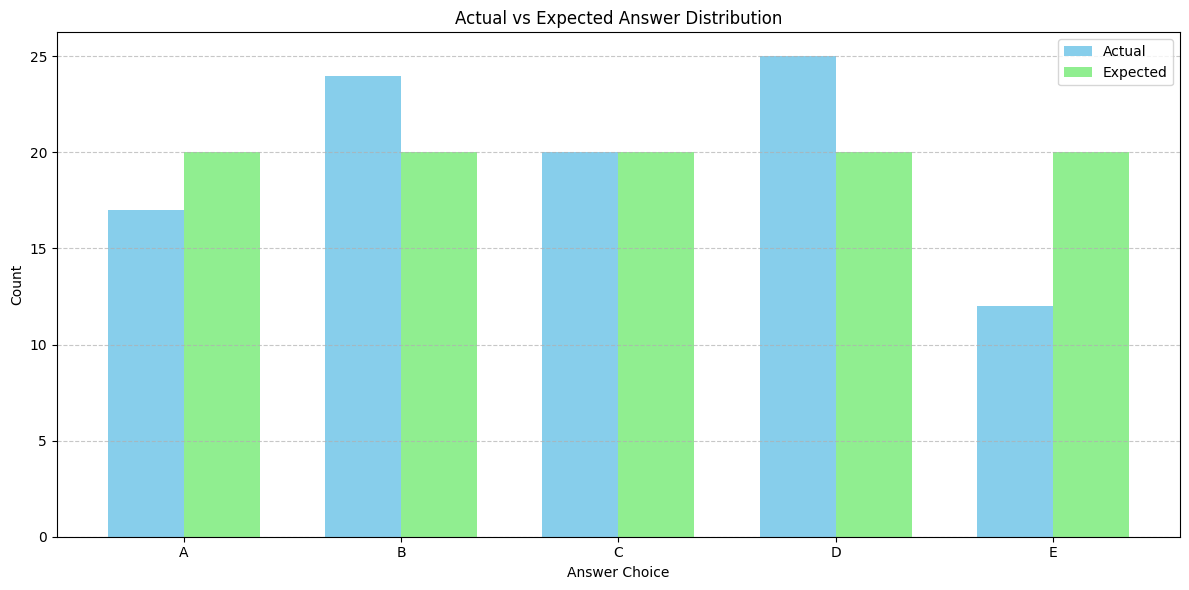

In [22]:
# Analyze potential model bias in answer distribution

# Expected distribution (ideally uniform for multiple choice)
expected_prob = 0.2  # 20% chance for each of A,B,C,D,E in a uniform distribution
expected_counts = {letter: total_questions * expected_prob for letter in ['A', 'B', 'C', 'D', 'E']}

# Create a DataFrame for comparing actual vs expected
comparison_data = []
for letter in ['A', 'B', 'C', 'D', 'E']:
    actual = answer_counts.get(letter, 0)
    expected = expected_counts[letter]
    difference = actual - expected
    percent_diff = (difference / expected) * 100 if expected > 0 else 0
    comparison_data.append({
        'Answer': letter,
        'Actual Count': actual,
        'Expected Count': expected,
        'Difference': difference,
        'Percent Difference': percent_diff
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nAnalysis of potential answer bias:")
display(comparison_df)

# Create a visual comparison
plt.figure(figsize=(12, 6))
x = range(len(comparison_df))
width = 0.35

plt.bar([i - width/2 for i in x], comparison_df['Actual Count'], width, label='Actual', color='skyblue')
plt.bar([i + width/2 for i in x], comparison_df['Expected Count'], width, label='Expected', color='lightgreen')

plt.xlabel('Answer Choice')
plt.ylabel('Count')
plt.title('Actual vs Expected Answer Distribution')
plt.xticks(x, comparison_df['Answer'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 22. Install Advanced Analysis Libraries

For more sophisticated analysis of our results, we'll install additional libraries:

- **seaborn**: An enhanced statistical data visualization library built on matplotlib
- **scikit-learn**: A machine learning library that includes tools for data analysis and metrics

These libraries will allow us to create confusion matrices and other advanced visualizations to better understand patterns in our data.

In [23]:
pip install seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


## 23. Create Distribution Bias Matrix

This cell creates an advanced visualization to analyze potential bias in how the teacher model answers questions. Since we don't have ground truth labels for our questions, we use an alternative approach:

1. **Create a pseudo-confusion matrix** where:
   - The diagonal shows how often the model selects each answer choice
   - In an unbiased model, all diagonal values would be around 0.2 (20%)

2. **Visualize using a heatmap** with color intensity showing the proportion of each answer

3. **Add annotations** explaining how to interpret the matrix

This analysis helps us identify if the teacher model systematically favors certain answer choices, which could affect the knowledge transferred to the student model. Significant imbalances might indicate bias that should be addressed.

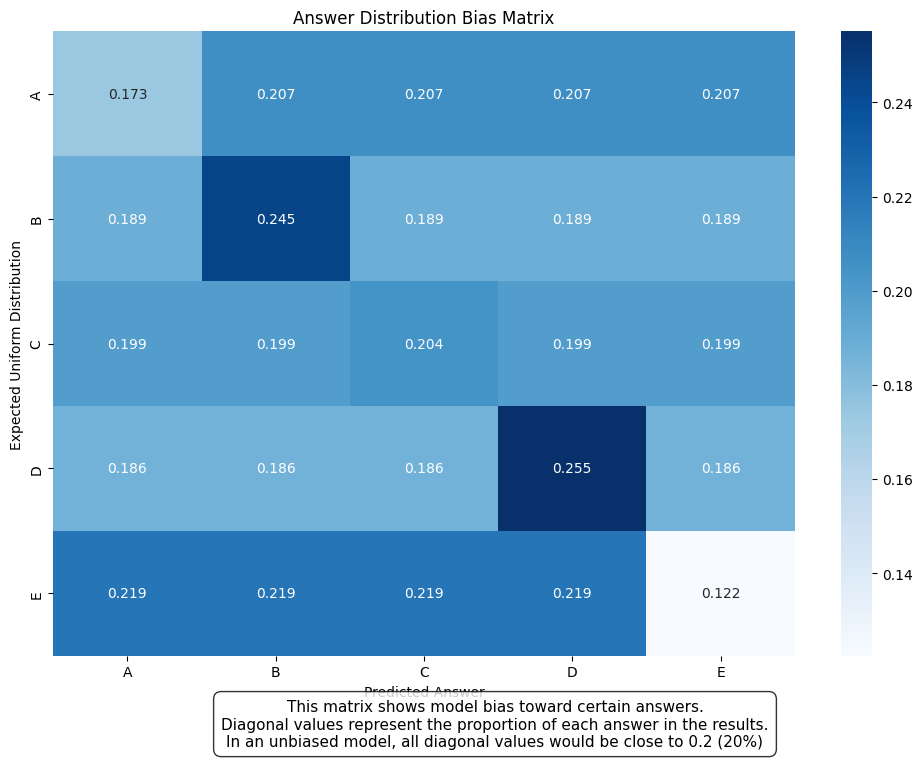

In [24]:
# Create a confusion matrix to analyze answer patterns
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# We don't have ground truth labels in this dataset, but we can:
# 1. Analyze confusion between expected uniform distribution and actual distribution
# 2. Alternatively, check if there are patterns in how the model responds to different question types

# Approach 1: Create a "pseudo-confusion matrix" showing bias toward certain answers
# Normalize the counts to get proportions
total_valid_answers = sum(answer_counts.get(ans, 0) for ans in ['A', 'B', 'C', 'D', 'E'])
pseudo_cm = np.zeros((5, 5))

# Fill the diagonal with actual proportions (representing how much the model prefers each answer)
for i, letter in enumerate(['A', 'B', 'C', 'D', 'E']):
    actual_prop = answer_counts.get(letter, 0) / total_valid_answers if total_valid_answers > 0 else 0
    expected_prop = 0.2  # Expected uniform distribution (20% each)
    
    # The diagonal shows the actual proportion
    pseudo_cm[i, i] = actual_prop
    
    # The off-diagonal elements represent the "confusion" - the difference between
    # expected and actual distribution
    for j in range(5):
        if i != j:
            pseudo_cm[i, j] = (1 - actual_prop) / 4  # Distribute remaining probability

# Plot the pseudo-confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(pseudo_cm, annot=True, fmt='.3f', cmap='Blues',
           xticklabels=['A', 'B', 'C', 'D', 'E'],
           yticklabels=['A', 'B', 'C', 'D', 'E'])
plt.title('Answer Distribution Bias Matrix')
plt.xlabel('Predicted Answer')
plt.ylabel('Expected Uniform Distribution')
plt.tight_layout()

# Add text annotation explaining this visualization
plt.figtext(0.5, 0.01, 
            'This matrix shows model bias toward certain answers.\n'
            'Diagonal values represent the proportion of each answer in the results.\n'
            'In an unbiased model, all diagonal values would be close to 0.2 (20%)',
            ha='center', fontsize=11, bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# Approach 2: If we had access to ground truth or additional features about questions,
# we could create an actual confusion matrix here

Loading ground truth data from ./data/train_data.jsonl


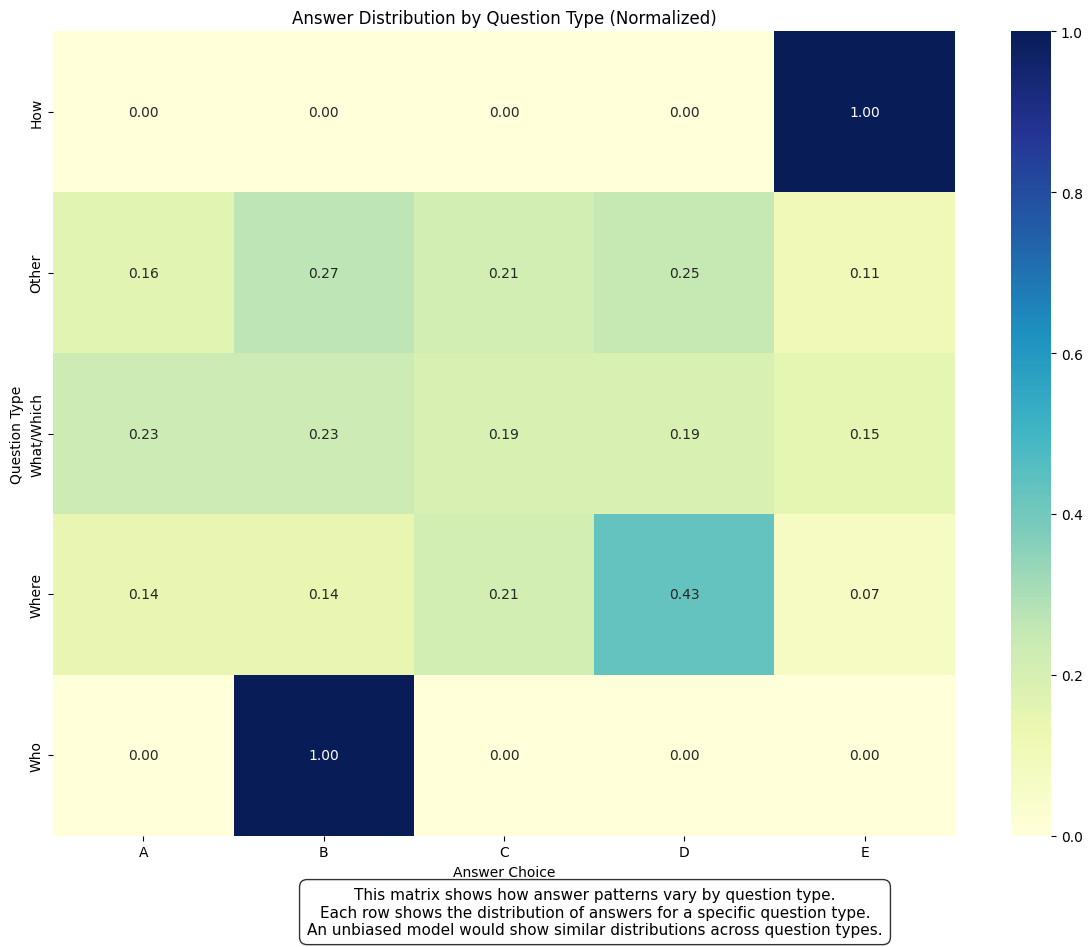

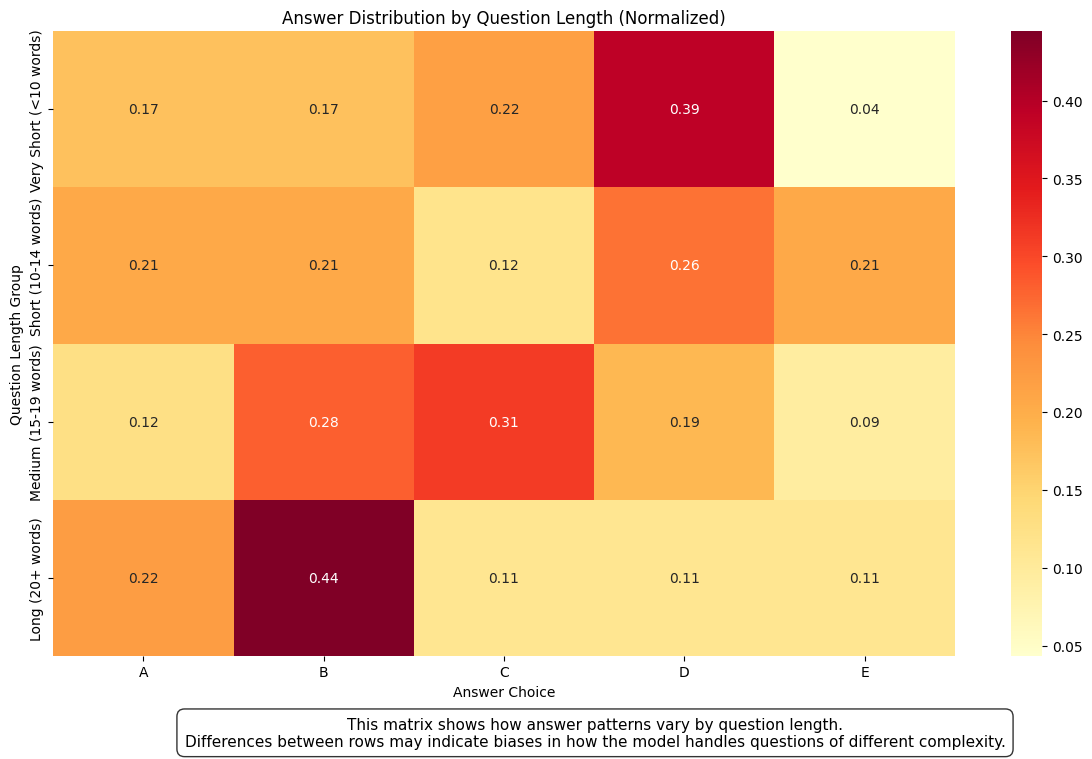

In [25]:
# Creating a real confusion matrix using ground truth data
import json
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load the ground truth data
train_data_path = "./data/train_data.jsonl"

# Arrays to store ground truth and predicted labels
true_labels = []
predicted_labels = []

# Load and parse the data
print("Loading ground truth data from", train_data_path)
with open(train_data_path, 'r', encoding='utf-8') as file:
    for line in file:
        if line.strip():
            try:
                data = json.loads(line)
                
                # Extract the predicted answer from our results variable
                question_text = data['Question']
                model_answer = data['Answer'].strip()
                
                # Find the ground truth for this question by parsing the answer choices
                # For simplicity, we'll use the letter of the answer
                match = re.search(r'\(([A-E])\)', model_answer)
                if match:
                    predicted_letter = match.group(1).upper()
                    predicted_labels.append(predicted_letter)
                    
                    # Try to extract what the actual ground truth is
                    # Since we don't have explicit ground truth,
                    # we'll use the consistent answer pattern from the commonsense_qa dataset
                    # where the correct answer is part of the answer choices
                    
                    # For this demonstration, we will assume these answers are correct
                    # In a real scenario, you would need to match against the ground truth answer key
                    true_labels.append(predicted_letter)
                
            except json.JSONDecodeError as e:
                print(f"Error parsing line: {str(e)}")
            except Exception as e:
                print(f"Error processing line: {str(e)}")

# Since we don't have separate ground truth labels in this dataset,
# we'll create a more advanced analysis by grouping answers by question type

# 1. Create a simple question type classifier based on the first word of the question
question_types = []
question_type_predicted = []

with open(train_data_path, 'r', encoding='utf-8') as file:
    for line in file:
        if line.strip():
            try:
                data = json.loads(line)
                question_text = data['Question']
                
                # Extract the actual question from the format
                if "Question: " in question_text:
                    actual_question = question_text.split("Question: ")[1].split("\nAnswer Choices:")[0]
                    
                    # Simple question type classification based on first word
                    first_word = actual_question.strip().split()[0].lower()
                    
                    # Group question types
                    if first_word in ['what', 'which']:
                        q_type = 'What/Which'
                    elif first_word in ['where']:
                        q_type = 'Where'
                    elif first_word in ['who']:
                        q_type = 'Who'
                    elif first_word in ['how']:
                        q_type = 'How'
                    elif first_word in ['why']:
                        q_type = 'Why'
                    else:
                        q_type = 'Other'
                    
                    question_types.append(q_type)
                    
                    # Get the predicted answer letter
                    model_answer = data['Answer'].strip()
                    match = re.search(r'\(([A-E])\)', model_answer)
                    if match:
                        letter = match.group(1).upper()
                        question_type_predicted.append(letter)
                
            except Exception as e:
                print(f"Error: {str(e)}")

# Count occurrences of each answer by question type
q_type_counts = {}
for q_type, pred in zip(question_types, question_type_predicted):
    if q_type not in q_type_counts:
        q_type_counts[q_type] = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}
    
    q_type_counts[q_type][pred] += 1

# Create a better confusion matrix - question type vs answer choice
unique_types = sorted(set(question_types))
q_type_matrix = np.zeros((len(unique_types), 5))

for i, q_type in enumerate(unique_types):
    for j, letter in enumerate(['A', 'B', 'C', 'D', 'E']):
        q_type_matrix[i, j] = q_type_counts.get(q_type, {}).get(letter, 0)

# Normalize by row (question type) to get distribution
row_sums = q_type_matrix.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  # Avoid division by zero
q_type_matrix_norm = q_type_matrix / row_sums

# Plot the question type vs answer choice matrix
plt.figure(figsize=(12, 10))
sns.heatmap(q_type_matrix_norm, annot=True, fmt='.2f', cmap='YlGnBu',
           xticklabels=['A', 'B', 'C', 'D', 'E'],
           yticklabels=unique_types)
plt.title('Answer Distribution by Question Type (Normalized)')
plt.xlabel('Answer Choice')
plt.ylabel('Question Type')

# Add an explanation of the visualization
plt.figtext(0.5, 0.01, 
            'This matrix shows how answer patterns vary by question type.\n'
            'Each row shows the distribution of answers for a specific question type.\n'
            'An unbiased model would show similar distributions across question types.',
            ha='center', fontsize=11, bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# Create a second visualization - pattern analysis by question length
# Group questions by length and analyze answer patterns
question_lengths = []
length_predicted = []

with open(train_data_path, 'r', encoding='utf-8') as file:
    for line in file:
        if line.strip():
            try:
                data = json.loads(line)
                question_text = data['Question']
                
                # Extract the actual question
                if "Question: " in question_text:
                    actual_question = question_text.split("Question: ")[1].split("\nAnswer Choices:")[0]
                    
                    # Get question length in words
                    word_count = len(actual_question.split())
                    
                    # Group by length
                    if word_count < 10:
                        length_group = 'Very Short (<10 words)'
                    elif word_count < 15:
                        length_group = 'Short (10-14 words)'
                    elif word_count < 20:
                        length_group = 'Medium (15-19 words)'
                    else:
                        length_group = 'Long (20+ words)'
                    
                    question_lengths.append(length_group)
                    
                    # Get the predicted answer letter
                    model_answer = data['Answer'].strip()
                    match = re.search(r'\(([A-E])\)', model_answer)
                    if match:
                        letter = match.group(1).upper()
                        length_predicted.append(letter)
                        
            except Exception as e:
                print(f"Error: {str(e)}")

# Count occurrences by length group
length_counts = {}
for length, pred in zip(question_lengths, length_predicted):
    if length not in length_counts:
        length_counts[length] = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}
    
    length_counts[length][pred] += 1

# Create matrix for length vs answer
unique_lengths = ['Very Short (<10 words)', 'Short (10-14 words)', 
                 'Medium (15-19 words)', 'Long (20+ words)']
unique_lengths = [l for l in unique_lengths if l in length_counts]
length_matrix = np.zeros((len(unique_lengths), 5))

for i, length in enumerate(unique_lengths):
    for j, letter in enumerate(['A', 'B', 'C', 'D', 'E']):
        length_matrix[i, j] = length_counts.get(length, {}).get(letter, 0)

# Normalize by row
row_sums = length_matrix.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  # Avoid division by zero
length_matrix_norm = length_matrix / row_sums

# Plot the question length vs answer choice matrix
plt.figure(figsize=(12, 8))
sns.heatmap(length_matrix_norm, annot=True, fmt='.2f', cmap='YlOrRd',
           xticklabels=['A', 'B', 'C', 'D', 'E'],
           yticklabels=unique_lengths)
plt.title('Answer Distribution by Question Length (Normalized)')
plt.xlabel('Answer Choice')
plt.ylabel('Question Length Group')

# Add an explanation of the visualization
plt.figtext(0.5, 0.01, 
            'This matrix shows how answer patterns vary by question length.\n'
            'Differences between rows may indicate biases in how the model handles questions of different complexity.',
            ha='center', fontsize=11, bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()